In [11]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from to_plot import plot_ball_timeseries
from scipy.signal import savgol_filter
from numpy.lib.stride_tricks import sliding_window_view
from sklearn.linear_model import LinearRegression
from scipy.signal import find_peaks



## Load all the files 

In [2]:
import glob
import json
import pandas as pd
import numpy as np
from tqdm import tqdm

# 1. Define your folder path (Change 'data_folder' to your actual path)
folder_path = "data/*.json" 
file_list = glob.glob(folder_path)

frames_list = []
m = 15  # Window size (needed for the spacer)

print(f"Found {len(file_list)} files. Starting concatenation...")

# 2. Loop through every file in the folder
for filepath in tqdm(file_list):
    # B. Convert to DataFrame
    df_temp = pd.read_json(filepath)
    df_temp = df_temp.T  # Transpose if necessary
    df_temp=df_temp[df_temp['visible']==1]
    df_temp=df_temp.drop(columns=['visible'])
    
    df_temp['filename'] = filepath
    
    # E. Add to list
    frames_list.append(df_temp)
    
    # F. Insert "Spacer" (NaNs) between files
    # This prevents the algorithm from analyzing a pattern that crosses two different matches
    # spacer = pd.DataFrame(index=range(m), columns=df_temp.columns)
    # spacer['y'] = np.nan       # Stumpy ignores windows with NaNs
    # spacer['filename'] = 'SPACER'
    # frames_list.append(spacer)

# 3. Concatenate all files into one distinct DataFrame
full_df = pd.concat(frames_list)

print(f"Successfully created 'full_df' with shape: {full_df.shape}")

Found 313 files. Starting concatenation...


  0%|          | 0/313 [00:00<?, ?it/s]

100%|██████████| 313/313 [00:23<00:00, 13.27it/s]

Successfully created 'full_df' with shape: (113673, 4)


In [13]:
df=pd.read_json("data/ball_data_79.json")
df=df.T
#let's not consider the frames where the ball is not detected (not visible)
print("Initial number of frames:",df.shape)
df=df[df['visible']==1]
print("Number of frames with ball visible:",df.shape)

Initial number of frames: (205, 4)
Number of frames with ball visible: (112, 4)


In [14]:
df

,x,y,visible,action
235716,1072,532,True,air
235717,1068,528,True,air
235718,1065,526,True,air
235719,1063,524,True,air
235720,1059,522,True,air
...,...,...,...,...
235856,1085.985149,979.5,True,bounce
235864,1096,1024,True,air
235876,1074,988,True,air
235877,1071,983,True,air


In [48]:
df=preprocess(df)
df

/tmp/ipykernel_154085/1210966645.py:13: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  vx_after = df['x'].shift(-window_size).ffill() - df['x']
/tmp/ipykernel_154085/1210966645.py:14: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  vy_after = df['y'].shift(-window_size).ffill() - df['y']


,x,y,visible,action,x_smooth,y_smooth,cosine_sim,speed_delta,y_distortion,x_distortion,acc_x,acc_y,acc_mag,y_diff,x_diff,dist_to_event
235716,1072,532,True,air,1071.904762,531.571429,1.000000,16.401220,1.0,1.0,0.0,0.0,0.0,9.523810,7.323810,20
235717,1068,528,True,air,1068.357143,528.642857,0.986903,9.292212,1.0,1.0,0.0,0.0,0.0,12.471429,9.185714,19
235718,1065,526,True,air,1065.071429,526.071429,0.997758,3.434757,1.0,1.0,0.0,0.0,0.0,13.559524,9.230952,18
235719,1063,524,True,air,1062.047619,523.857143,0.979987,0.899481,1.0,1.0,0.0,0.0,0.0,14.758730,9.047619,17
235720,1059,522,True,air,1059.476190,522.238095,0.914180,-2.201196,1.0,1.0,0.0,0.0,0.0,16.302381,8.545238,16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235856,1085.985149,979.5,True,bounce,1085.471240,969.738095,-0.802370,-45.605301,-1.0,-1.0,0.0,0.0,0.0,4.077463,-130.071429,1
235864,1096,1024,True,air,1092.138614,1006.285714,-0.885440,-13.380219,-1.0,-1.0,0.0,0.0,0.0,9.695521,-90.371429,0
235876,1074,988,True,air,1077.353960,1000.250000,-0.819496,-8.657394,-1.0,1.0,0.0,0.0,0.0,15.713720,-49.161905,1
235877,1071,983,True,air,1050.213225,964.964286,-0.275758,66.741592,1.0,1.0,0.0,0.0,0.0,18.050896,-14.883333,2


In [4]:
import numpy as np

def cosine_similarity_rows(df, window_size=4, threshold=1e-5):
    # --- 1. Calculate Vectors ---
    
    # Vector A (Incoming): Points from Past -> Current
    # (Current Position - Past Position)
    vx_before = df['x_smooth'] - df['x_smooth'].shift(window_size).bfill()
    vy_before = df['y_smooth'] - df['y_smooth'].shift(window_size).bfill()
    
    # Vector B (Outgoing): Points from Current -> Future
    # FIX: Swapped order to (Future - Current) so it points Forward
    vx_after = df['x'].shift(-window_size).ffill() - df['x']
    vy_after = df['y'].shift(-window_size).ffill() - df['y']
    
    # --- 2. Create Arrays with Correct Shape ---
    # Stack them and Transpose (.T) so shape is (500, 2)
    A = np.array([vx_before, vy_before], dtype=np.float32).T
    B = np.array([vx_after, vy_after], dtype=np.float32).T 
    
    # --- 3. Dot Product (Row-by-Row) ---
    # axis=1 now correctly sums x*x + y*y for each frame
    dot_products = np.sum(A * B, axis=1)
    
    # --- 4. Magnitudes ---
    norm_A = np.linalg.norm(A, axis=1)
    norm_B = np.linalg.norm(B, axis=1)
    
    # --- 5. Safety Mask ---
    valid_mask = (norm_A > threshold) & (norm_B > threshold)
    
    # --- 6. Calculate ---
    similarities = np.ones(len(df), dtype=np.float32) # Default to 1.0 (Straight)
    
    # Only divide where safe
    similarities[valid_mask] = dot_products[valid_mask] / (norm_A[valid_mask] * norm_B[valid_mask])
    
    # Calculate speed change (Acceleration magnitude roughly)
    delta_speed = norm_B - norm_A 
    
    #return np.clip(similarities, -1.0, 1.0), delta_speed
    return similarities, delta_speed

In [ ]:
import numpy as np

def y_direction_similarity(df, window_size=4, threshold=1e-5):
    # --- 1. Calculate Y Velocities Only ---
    # Velocity Before (Past -> Current)
    vy_before = df['y_smooth'] - df['y_smooth'].shift(window_size).bfill()
    
    # Velocity After (Current -> Future)
    # Remember: (Future - Current) to point forward in time
    vy_after = df['y_smooth'].shift(-window_size).ffill() - df['y_smooth']
    
    # --- 2. Calculate "1D Cosine Similarity" ---
    # For 1D numbers, this is just: (a * b) / (|a| * |b|)
    # This results in:
    #   +1.0 if they move in the same direction
    #   -1.0 if they move in opposite directions
    
    dot_product = vy_before * vy_after
    magnitudes  = np.abs(vy_before) * np.abs(vy_after)
    
    # --- 3. Safety Mask (Noise Filter) ---
    # If the ball is moving extremely slowly vertically (e.g. at the peak of an arc),
    # we ignore it to prevent division by zero or noise flipping.
    valid_mask = (np.abs(vy_before) > threshold) & (np.abs(vy_after) > threshold)
    
    # Initialize with 1.0 (Assume continuity/no change)
    similarity_y = np.ones(len(df), dtype=np.float32)
    
    # Perform division only on valid data
    similarity_y[valid_mask] = dot_product[valid_mask] / magnitudes[valid_mask]
    
    # --- 4. Clip result ---
    # (Though mathematically 1D cosine is always exactly -1 or 1, float errors might give 1.0000001)
    #return np.clip(similarity_y, -1.0, 1.0)
    return similarity_y


def x_direction_similarity(df, window_size=4, threshold=1e-5):
    # --- 1. Calculate Y Velocities Only ---
    # Velocity Before (Past -> Current)
    vy_before = df['x_smooth'] - df['x_smooth'].shift(window_size).bfill()
    
    # Velocity After (Current -> Future)
    # Remember: (Future - Current) to point forward in time
    vy_after = df['x_smooth'].shift(-window_size).ffill() - df['x_smooth']
    
    # --- 2. Calculate "1D Cosine Similarity" ---
    # For 1D numbers, this is just: (a * b) / (|a| * |b|)
    # This results in:
    #   +1.0 if they move in the same direction
    #   -1.0 if they move in opposite directions
    
    dot_product = vy_before * vy_after
    magnitudes  = np.abs(vy_before) * np.abs(vy_after)
    
    # --- 3. Safety Mask (Noise Filter) ---
    # If the ball is moving extremely slowly vertically (e.g. at the peak of an arc),
    # we ignore it to prevent division by zero or noise flipping.
    valid_mask = (np.abs(vy_before) > threshold) & (np.abs(vy_after) > threshold)
    
    # Initialize with 1.0 (Assume continuity/no change)
    similarity_y = np.ones(len(df), dtype=np.float32)
    
    # Perform division only on valid data
    similarity_y[valid_mask] = dot_product[valid_mask] / magnitudes[valid_mask]
    
    # --- 4. Clip result ---
    # (Though mathematically 1D cosine is always exactly -1 or 1, float errors might give 1.0000001)
    # return np.clip(similarity_y, -1.0, 1.0)
    return similarity_y

In [8]:


def get_window_slope(data, window_size):
    """
    Calculates the slope (velocity) of a moving window efficiently.
    Slope m = (N*sum(xy) - sum(x)sum(y)) / (N*sum(x^2) - sum(x)^2)
    """
    # 1. Create a view of the array with windows (shape: N, window_size)
    windows = sliding_window_view(data, window_size)
    
    # 2. X is just indices [0, 1, 2, ... w-1]
    x = np.arange(window_size)
    
    # 3. Pre-calculate constants for the linear regression formula
    N = window_size
    sum_x = np.sum(x)
    sum_x_sq = np.sum(x**2)
    delta = N * sum_x_sq - sum_x**2
    
    # 4. Calculate Y terms per window (vectorized)
    sum_y = np.sum(windows, axis=1)
    sum_xy = np.sum(windows * x, axis=1)
    
    # 5. Calculate Slope (m) for every window
    slopes = (N * sum_xy - sum_x * sum_y) / delta
    
    return slopes

def windowed_acceleration(df, window_size=5):
    # FIX: Force inputs to float arrays immediately.
    # This prevents the "loop of ufunc does not support argument 0 of type int64" error.
    vx_data = df['x_smooth'].values.astype(float)
    vy_data = df['y_smooth'].values.astype(float)
    
    # 1. Get Trends (Velocity of the window)
    vx_trend = get_window_slope(vx_data, window_size)
    vy_trend = get_window_slope(vy_data, window_size)
    
    # 2. Calculate Acceleration (Change in Slope)
    ax = np.diff(vx_trend)
    ay = np.diff(vy_trend)
    
    # 3. Pad the result to match original length
    # The sliding window reduces length by (window_size - 1)
    # The diff reduces length by 1
    # Total lost = window_size
    
    pad_start = window_size // 2
    # Ensure pad_end is not negative
    pad_end = max(0, len(df) - len(ax) - pad_start)
    
    ax = np.pad(ax, (pad_start, pad_end), constant_values=0)
    ay = np.pad(ay, (pad_start, pad_end), constant_values=0)
    
    return ax, ay

In [39]:
def delta_avg_position(df,N=5):

    # 1. Define your window size (N=5)
    N = 5

    # 2. Calculate the base rolling mean (This contains avg of [t-4 ... t])
    # min_periods=1 ensures you get values even at the edges (optional)
    # We calculate on both 'x' and 'y' columns simultaneously
    rolling_base = df[['x_smooth', 'y_smooth']].rolling(window=N, min_periods=1).mean()

    # 3. GET PAST AVERAGE (t-5 to t-1)
    # We shift the base result by +1 so it doesn't include the current point 't'
    # It now represents the average of the previous N points
    before= rolling_base.shift(1)

    
    # 4. GET FUTURE AVERAGE (t+1 to t+5)
    # We look into the future. The rolling mean calculated at index (t+N) 
    # represents the average of (t+1 ... t+N). We pull that value back to 't'.
    after = rolling_base.shift(-N)

    return before['x_smooth'].bfill()-after['x_smooth'].ffill(),before['y_smooth'].bfill()-after['y_smooth'].ffill()


In [ ]:
def fit_piecewise_linear(df, breakpoints):
    """
    Fits a straight line (Linear Regression) between each pair of breakpoints.
    
    Args:
        df: DataFrame containing the 'y' column.
        breakpoints: List of frame indices where the hits/bounces happen.
        
    Returns:
        linear_fit: Array of the same length as df, containing the straight lines.
        line_equations: List of dictionaries with slope/intercept for each segment.
    """
    # 1. Prepare the full list of boundaries
    # We add 0 (start) and len(df) (end) to ensure we cover the whole video
    # Sort and remove duplicates just in case
    boundaries = sorted(list(set([0, len(df)] + list(breakpoints))))
    
    # Prepare an array to hold the linear reconstruction (filled with NaNs initially)
    linear_fit = np.full(len(df), np.nan)
    
    # List to store the equation of each line: (slope, intercept)
    line_equations = []

    # 2. Iterate through each segment
    for i in range(len(boundaries) - 1):
        start, end = int(boundaries[i]), int(boundaries[i+1])
        
        # Extract the segment data
        # Reshape X for sklearn (needs 2D array [[1], [2], [3]])
        X_segment = np.arange(start, end).reshape(-1, 1) 
        y_segment = df['y'].iloc[start:end].values
        
        # Safety check: Skip segments that are too small to fit a line
        if len(y_segment) < 2:
            continue
            
        # 3. Fit the Linear Model
        model = LinearRegression()
        model.fit(X_segment, y_segment)
        
        # Predict the straight line values for this segment
        y_pred = model.predict(X_segment)
        
        # Store in our result array
        linear_fit[start:end] = y_pred
        
        # Store parameters (Slope = Velocity, Intercept = Start Pos)
        line_equations.append({
            'segment': (start, end),
            'slope': model.coef_[0],      # Vertical Velocity (pixels/frame)
            'intercept': model.intercept_ # Projected starting position
        })
        
    return linear_fit, line_equations

In [47]:
def merge_close_points(points, threshold=10):
    """
    Groups points that are within 'threshold' frames of each other 
    and returns the average frame index for each group.
    """
    if len(points) == 0:
        return np.array([], dtype=int)
    
    # Sort points just in case
    sorted_pts = np.sort(points)
    
    merged_points = []
    current_cluster = [sorted_pts[0]]
    
    for i in range(1, len(sorted_pts)):
        # If this point is close to the last one in the cluster, add it
        if sorted_pts[i] - current_cluster[-1] < threshold:
            current_cluster.append(sorted_pts[i])
        else:
            # Cluster finished: calculate mean and save
            mean_frame = np.mean(current_cluster)
            merged_points.append(mean_frame)
            # Start new cluster
            current_cluster = [sorted_pts[i]]
            
    # Don't forget the last cluster
    if current_cluster:
        merged_points.append(np.mean(current_cluster))
        
    # Return as integers (Frame indices must be ints)
    return np.array(merged_points, dtype=int)

def calculate_peak_distances(total_frames, peak_indices):
    """
    For every frame in the video, calculate the distance to the closest peak.
    Returns an array of length 'total_frames'.
    """
    if len(peak_indices) == 0:
        return np.zeros(total_frames)
    
    # Create an array of all frame numbers [0, 1, 2, ... N]
    all_frames = np.arange(total_frames)
    
    # Efficiently find min distance for every frame
    # We subtract every frame from every peak, finding the absolute min
    # Shape: (Total_Frames, 1) - (1, Num_Peaks)
    distances = np.abs(all_frames[:, None] - peak_indices[None, :])
    
    # Get the minimum value along the rows (closest peak for each frame)
    min_distances = np.min(distances, axis=1)
    
    return min_distances

In [ ]:
def preprocess(df):
    #create a smooth version for better fixing of censors sensibility
    df['x_smooth'] = savgol_filter(df['x'], window_length=7, polyorder=2)
    df['y_smooth'] = savgol_filter(df['y'], window_length=7, polyorder=2)
    
    #cosine similarity between velcoity before/after and also difference of speed 
    df['cosine_sim'],df['speed_delta'] = cosine_similarity_rows(df, 4)
    
    #distortion of the ball direction (does it keep same direction of change), on the y-axis might the most significant
    # df['y_distortion']=y_direction_similarity(df,3)
    # df['x_distortion']=x_direction_similarity(df,3)
    
    #get the acceleration 
    ax, ay = windowed_acceleration(df, window_size=10)

    # Total magnitude of windowed acceleration
    acc_magnitude = np.sqrt(ax**2 + ay**2)

    df['acc_x'] = ax
    df['acc_y'] = ay
    df['acc_mag'] = acc_magnitude
    
    # #The avg disposition of the ball after a data point
    # df['y_diff'],df['x_diff']=delta_avg_position(df)
    
    
    #detect pick points and compute distant to events
    y_data = df['y_smooth'].values
    peaks, _ = find_peaks(y_data, prominence=20, distance=5)
    valleys, _ = find_peaks(-y_data, prominence=20, distance=5)
    raw_points = np.concatenate([peaks, valleys])

    # 2. Merge Close Points
    # final_events contains 0-based indices (e.g., 0, 10, 50)
    final_events = merge_close_points(raw_points, threshold=15)

    # --- CRITICAL FIX: MAP TO DATAFRAME INDEX ---
    # We use these 0-based positions to grab the REAL frame numbers from df.index
    actual_event_frames = df.index[final_events]
    old_event_frames=df.index[raw_points]
    # 3. Calculate Distances
    # We pass the 0-based 'final_events' because 'calculate_peak_distances' 
    # generates a 0-based range internally.
    dist_array = calculate_peak_distances(len(df), final_events)
    df['dist_to_event'] = dist_array  # Assigning to DF automatically aligns it to DF index
    
    return df 

        
    
    

# -----------------------------------

In [19]:
model_df=df.drop(columns=['visible','action','x','y'])

In [25]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import seaborn as sns


scaler = StandardScaler()
X_scaled = scaler.fit_transform(model_df)

# Fit K-Means
kmeans = KMeans(n_clusters=2, random_state=42, n_init=10)
df['cluster'] = kmeans.fit_predict(X_scaled)


In [26]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Create the contingency table
# Rows = Actual Actions (Ground Truth)
# Columns = Predicted Clusters (0, 1, 2)
crosstab = pd.crosstab(df['action'], df['cluster'])

print("--- Confusion Matrix (Counts) ---")
print(crosstab)

--- Confusion Matrix (Counts) ---
cluster   0   1
action         
air      97  11
bounce    0   2
hit       0   2


In [33]:
import numpy as np
import pandas as pd
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# --- STEP 1: PREPARE YOUR FEATURES ---
# Assuming you have these 1D arrays from our previous steps:
# 1. speed (from velocity vector magnitude)
# 2. acceleration (from acceleration vector magnitude)
# 3. angle_std (from rolling std of arctan2 angles)

# IMPORTANT: These arrays must be the same length.
# diff() and rolling() make arrays shorter or create NaNs. 
# We must trim or fill them to align perfectly.

# Let's clean up NaNs first (replace with 0 for start/end of lists)
# speed       = np.nan_to_num(speed)
# acc_mag     = np.nan_to_num(acc_mag) 
# angle_std   = np.nan_to_num(angle_std)

# Stack them into a single matrix (N rows, 3 columns)
X_features = model_df

# --- STEP 2: SCALE THE DATA (CRITICAL) ---
# DBSCAN uses distance. If Speed is 1000 and Angle STD is 0.5, 
# DBSCAN will only care about Speed. We must scale them to be equal.
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_features)

# --- STEP 3: RUN DBSCAN ---
# eps: The maximum distance between two samples for one to be considered as in the neighborhood of the other.
# min_samples: The number of samples in a neighborhood for a point to be considered as a core point.
model = DBSCAN(eps=0.5, min_samples=2)
labels = model.fit_predict(X_scaled)

# --- STEP 4: EXTRACT RESULTS ---
# DBSCAN labels standard clusters as 0, 1, 2...
# It labels ANOMALIES as -1
anomaly_indices = np.where(labels == -1)[0]

print(f"Total Frames: {len(labels)}")
print(f"Anomalies Detected: {len(anomaly_indices)}")
print(f"Anomaly Frame Indices: {anomaly_indices}")


Total Frames: 112
Anomalies Detected: 47
Anomaly Frame Indices: [ 18  19  20  21  22  23  24  26  38  42  43  44  45  46  47  48  49  59
  62  63  64  65  66  67  68  69  70  71  72  73  74  75  76  77  78  79
 101 102 103 104 105 106 107 108 109 110 111]


In [38]:
labels

array([ 0,  0,  0,  0,  0,  0,  0,  1,  1,  1,  0,  0,  0,  0,  2,  2,  2,
        3, -1, -1, -1, -1, -1, -1, -1,  4, -1,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  1,  1, -1,  2,  2,  3, -1, -1, -1, -1, -1, -1, -1, -1,  4,
        0,  0,  0,  0,  0,  0,  0,  0, -1,  5,  5, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  2,  2,  0, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1])

In [39]:
df['cluster']=labels

In [40]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Create the contingency table
# Rows = Actual Actions (Ground Truth)
# Columns = Predicted Clusters (0, 1, 2)
crosstab = pd.crosstab(df['action'], df['cluster'])

print("--- Confusion Matrix (Counts) ---")
print(crosstab)

--- Confusion Matrix (Counts) ---
cluster  -1   0   1   2   3   4   5
action                             
air      43  47   5   7   2   2   2
bounce    2   0   0   0   0   0   0
hit       2   0   0   0   0   0   0


# -----------------------

Peaks & Bounces found at frames: [    12     44     83 ... 113593 113622 113651]


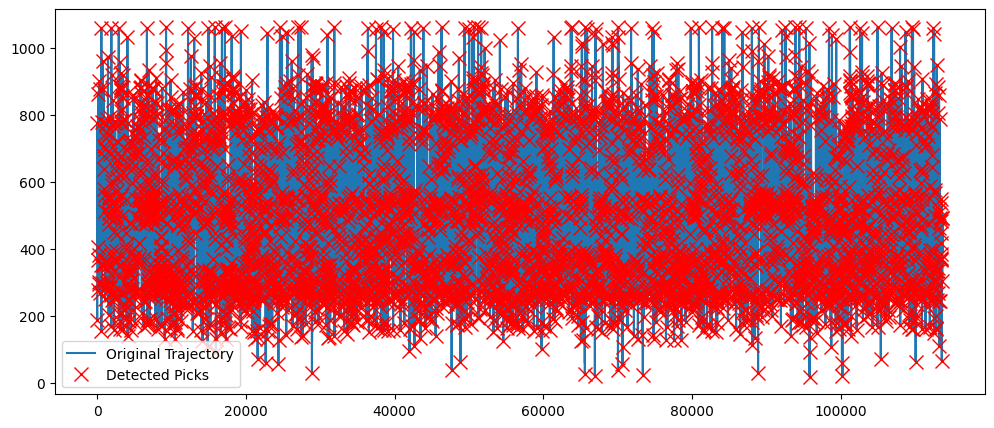

NameError: name 'fit_piecewise_linear' is not defined

In [17]:
from scipy.signal import find_peaks

# Data
y = df['y'].values

# --- STRATEGY: Find Peaks and Valleys ---
# Bounces can be peaks (top of arc) or valleys (hitting floor)
# depending on your coordinate system. We look for both.

# 1. Find "Valleys" (Local Minima) - often floor bounces
# We invert y (-y) to turn valleys into peaks
valleys, _ = find_peaks(-y, prominence=10, distance=10)

# 2. Find "Peaks" (Local Maxima) - top of the arc
peaks, _ = find_peaks(y, prominence=10, distance=10)

# 3. Combine them into a single list of "Event" frames
# We sort them so they appear in order
all_picks = np.sort(np.concatenate([peaks, valleys]))

print(f"Peaks & Bounces found at frames: {all_picks}")

# --- VISUALIZE ---
plt.figure(figsize=(12, 5))
plt.plot(y, label='Original Trajectory')
plt.plot(all_picks, y[all_picks], "x", color='red', markersize=10, label='Detected Picks')
plt.legend()
plt.show()

# --- OPTIONAL: Use these as your Linear Breakpoints ---
# Now you can feed 'all_picks' into your previous linear_fitting function
linear_y, equations = fit_piecewise_linear(df, breakpoints=all_picks)

In [18]:
import numpy as np
from sklearn.linear_model import LinearRegression

def fit_piecewise_linear(df, breakpoints):
    """
    Fits a straight line (Linear Regression) between each pair of breakpoints.
    
    Args:
        df: DataFrame containing the 'y' column.
        breakpoints: List of frame indices where the hits/bounces happen.
        
    Returns:
        linear_fit: Array of the same length as df, containing the straight lines.
        line_equations: List of dictionaries with slope/intercept for each segment.
    """
    # 1. Prepare the full list of boundaries
    # We add 0 (start) and len(df) (end) to ensure we cover the whole video
    # Sort and remove duplicates just in case
    boundaries = sorted(list(set([0, len(df)] + list(breakpoints))))
    
    # Prepare an array to hold the linear reconstruction (filled with NaNs initially)
    linear_fit = np.full(len(df), np.nan)
    
    # List to store the equation of each line: (slope, intercept)
    line_equations = []

    # 2. Iterate through each segment
    for i in range(len(boundaries) - 1):
        start, end = int(boundaries[i]), int(boundaries[i+1])
        
        # Extract the segment data
        # Reshape X for sklearn (needs 2D array [[1], [2], [3]])
        X_segment = np.arange(start, end).reshape(-1, 1) 
        y_segment = df['y'].iloc[start:end].values
        
        # Safety check: Skip segments that are too small to fit a line
        if len(y_segment) < 2:
            continue
            
        # 3. Fit the Linear Model
        model = LinearRegression()
        model.fit(X_segment, y_segment)
        
        # Predict the straight line values for this segment
        y_pred = model.predict(X_segment)
        
        # Store in our result array
        linear_fit[start:end] = y_pred
        
        # Store parameters (Slope = Velocity, Intercept = Start Pos)
        line_equations.append({
            'segment': (start, end),
            'slope': model.coef_[0],      # Vertical Velocity (pixels/frame)
            'intercept': model.intercept_ # Projected starting position
        })
        
    return linear_fit, line_equations

In [ ]:
from scipy.signal import find_peaks

# Data
y = df['y'].values

# --- STRATEGY: Find Peaks and Valleys ---
# Bounces can be peaks (top of arc) or valleys (hitting floor)
# depending on your coordinate system. We look for both.

# 1. Find "Valleys" (Local Minima) - often floor bounces
# We invert y (-y) to turn valleys into peaks
valleys, _ = find_peaks(-y, prominence=10, distance=10)

# 2. Find "Peaks" (Local Maxima) - top of the arc
peaks, _ = find_peaks(y, prominence=10, distance=10)

# 3. Combine them into a single list of "Event" frames
# We sort them so they appear in order
all_picks = np.sort(np.concatenate([peaks, valleys]))

print(f"Peaks & Bounces found at frames: {all_picks}")

# --- VISUALIZE ---
plt.figure(figsize=(12, 5))
plt.plot(y, label='Original Trajectory')
plt.plot(all_picks, y[all_picks], "x", color='red', markersize=10, label='Detected Picks')
plt.legend()
plt.show()

# --- OPTIONAL: Use these as your Linear Breakpoints ---
# Now you can feed 'all_picks' into your previous linear_fitting function
linear_y, equations = fit_piecewise_linear(df, breakpoints=all_picks)

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

def merge_close_points(points, threshold=10):
    """
    Groups points that are within 'threshold' frames of each other 
    and returns the average frame index for each group.
    """
    if len(points) == 0:
        return np.array([], dtype=int)
    
    # Sort points just in case
    sorted_pts = np.sort(points)
    
    merged_points = []
    current_cluster = [sorted_pts[0]]
    
    for i in range(1, len(sorted_pts)):
        # If this point is close to the last one in the cluster, add it
        if sorted_pts[i] - current_cluster[-1] < threshold:
            current_cluster.append(sorted_pts[i])
        else:
            # Cluster finished: calculate mean and save
            mean_frame = np.mean(current_cluster)
            merged_points.append(mean_frame)
            # Start new cluster
            current_cluster = [sorted_pts[i]]
            
    # Don't forget the last cluster
    if current_cluster:
        merged_points.append(np.mean(current_cluster))
        
    # Return as integers (Frame indices must be ints)
    return np.array(merged_points, dtype=int)

def calculate_peak_distances(total_frames, peak_indices):
    """
    For every frame in the video, calculate the distance to the closest peak.
    Returns an array of length 'total_frames'.
    """
    if len(peak_indices) == 0:
        return np.zeros(total_frames)
    
    # Create an array of all frame numbers [0, 1, 2, ... N]
    all_frames = np.arange(total_frames)
    
    # Efficiently find min distance for every frame
    # We subtract every frame from every peak, finding the absolute min
    # Shape: (Total_Frames, 1) - (1, Num_Peaks)
    distances = np.abs(all_frames[:, None] - peak_indices[None, :])
    
    # Get the minimum value along the rows (closest peak for each frame)
    min_distances = np.min(distances, axis=1)
    
    return min_distances

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

# ... [Your existing merge_close_points and calculate_peak_distances functions stay the same] ...

# --- MAIN WORKFLOW ---

# 1. Detect Raw Peaks (on values only)


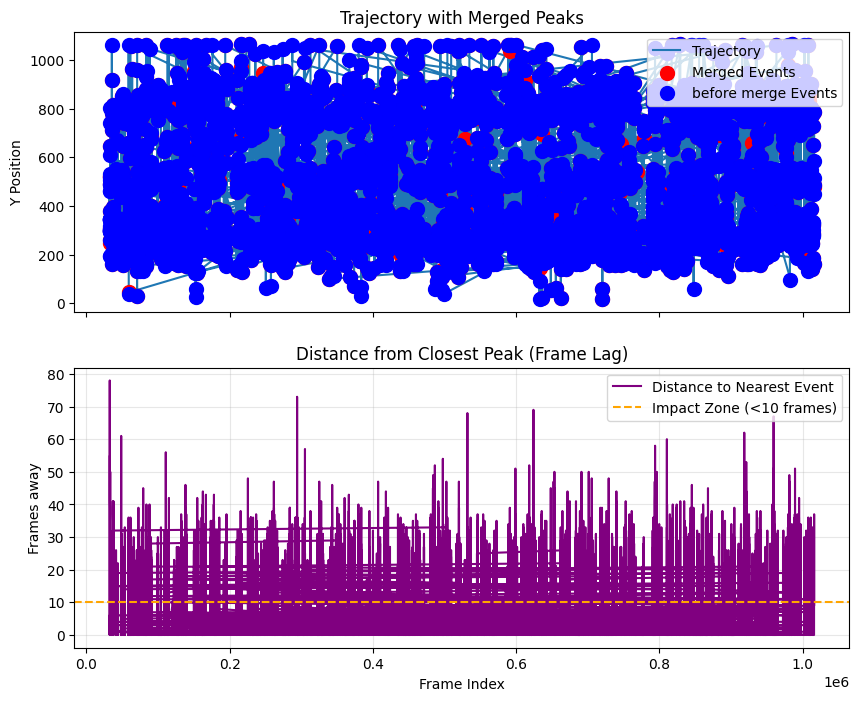

In [ ]:

y_data = df['y'].values
peaks, _ = find_peaks(y_data, prominence=20, distance=5)
valleys, _ = find_peaks(-y_data, prominence=20, distance=5)
raw_points = np.concatenate([peaks, valleys])

# 2. Merge Close Points
# final_events contains 0-based indices (e.g., 0, 10, 50)
final_events = merge_close_points(raw_points, threshold=15)

# --- CRITICAL FIX: MAP TO DATAFRAME INDEX ---
# We use these 0-based positions to grab the REAL frame numbers from df.index
actual_event_frames = df.index[final_events]
old_event_frames=df.index[raw_points]
# 3. Calculate Distances
# We pass the 0-based 'final_events' because 'calculate_peak_distances' 
# generates a 0-based range internally.
dist_array = calculate_peak_distances(len(df), final_events)
df['dist_to_event'] = dist_array  # Assigning to DF automatically aligns it to DF index

# --- VISUALIZATION ---
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

# Plot 1: Positions and Merged Peaks
# pandas plot automatically uses the DataFrame index (e.g., 230,000)
ax1.plot(df.index, df['y'], label='Trajectory')

# FIX: Use 'actual_event_frames' for X, and look up Y using .loc
ax1.scatter(actual_event_frames, df.loc[actual_event_frames, 'y'], 
            color='red', s=100, zorder=5, label='Merged Events')

ax1.scatter(old_event_frames, df.loc[old_event_frames, 'y'], 
            color='blue', s=100, zorder=5, label='before merge Events')


ax1.set_title('Trajectory with Merged Peaks')
ax1.set_ylabel('Y Position')
ax1.legend()

# Plot 2: Distance to Nearest Peak
# This will now align perfectly because df['dist_to_event'] shares the same index
ax2.plot(df.index, df['dist_to_event'], color='purple', label='Distance to Nearest Event')
ax2.set_title('Distance from Closest Peak (Frame Lag)')
ax2.set_ylabel('Frames away')
ax2.set_xlabel('Frame Index')
ax2.grid(True, alpha=0.3)

# Add threshold line
ax2.axhline(10, color='orange', linestyle='--', label='Impact Zone (<10 frames)')
ax2.legend()

plt.show()

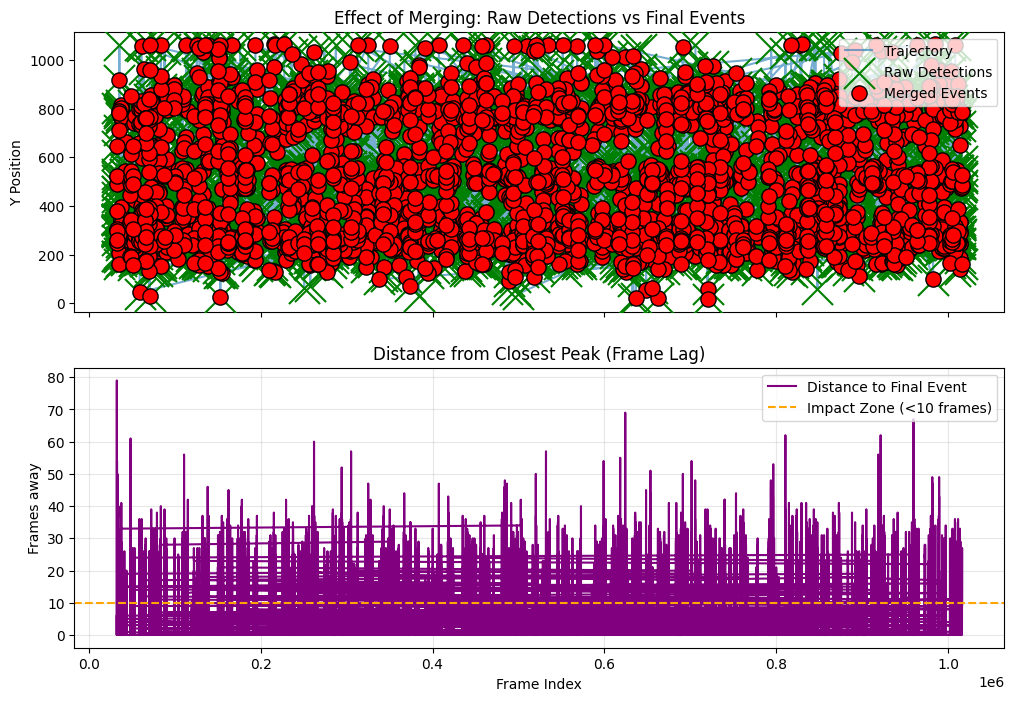

In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

# [Keep your merge_close_points and calculate_peak_distances functions]

# --- MAIN WORKFLOW ---

# 1. Detect Raw Peaks (on values only)
y_data = df['y'].values
peaks, _ = find_peaks(y_data, prominence=15, distance=10)
valleys, _ = find_peaks(-y_data, prominence=15, distance=10)
raw_points = np.concatenate([peaks, valleys])

# 2. Merge Close Points
final_events = merge_close_points(raw_points, threshold=15)

# --- MAP TO DATAFRAME INDEX ---
# We need both raw and merged points in "DataFrame Index" format
actual_raw_frames = df.index[raw_points]
actual_final_frames = df.index[final_events]

# 3. Calculate Distances (using the MERGED events for the metric)
dist_array = calculate_peak_distances(len(df), final_events)
df['dist_to_event'] = dist_array

# --- VISUALIZATION ---
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

# Plot 1: Trajectory + Raw vs Merged
ax1.plot(df.index, df['y'], label='Trajectory', alpha=0.6)

# Plot RAW detections (Before Merging) - Small Green 'x'
ax1.scatter(actual_raw_frames, df.loc[actual_raw_frames, 'y'], 
            color='green', marker='x', s=500, label='Raw Detections', zorder=4)

# Plot MERGED events (After Merging) - Large Red Dots
ax1.scatter(actual_final_frames, df.loc[actual_final_frames, 'y'], 
            color='red', s=120, edgecolors='black', label='Merged Events', zorder=5)

ax1.set_title('Effect of Merging: Raw Detections vs Final Events')
ax1.set_ylabel('Y Position')
ax1.legend()

# Plot 2: Distance to Nearest Peak
ax2.plot(df.index, df['dist_to_event'], color='purple', label='Distance to Final Event')
ax2.set_title('Distance from Closest Peak (Frame Lag)')
ax2.set_ylabel('Frames away')
ax2.set_xlabel('Frame Index')
ax2.grid(True, alpha=0.3)
ax2.axhline(10, color='orange', linestyle='--', label='Impact Zone (<10 frames)')
ax2.legend()

plt.show()

In [117]:
model_df=df.drop(columns=['visible','action','x','y','past_avg_x','past_avg_y','future_avg_x','future_avg_y'])

In [119]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import seaborn as sns


scaler = StandardScaler()
X_scaled = scaler.fit_transform(model_df)

# Fit K-Means
kmeans = KMeans(n_clusters=2, random_state=42, n_init=20)
df['cluster'] = kmeans.fit_predict(X_scaled)


In [120]:
model_df

,cosine_sim,speed_delta,y_distortion,x_distortion,acc_x,acc_y,acc_mag,impact_score,cluster,dist_to_event
235716,1.000000,15.542860,1.0,1.0,0.0,0.0,0.0,0.0,0,20
235717,0.997829,9.454771,1.0,1.0,0.0,0.0,0.0,0.0,0,19
235718,0.989376,4.515751,1.0,1.0,0.0,0.0,0.0,0.0,0,18
235719,0.975331,-0.034468,1.0,1.0,0.0,0.0,0.0,0.0,0,17
235720,0.954027,-2.967013,1.0,1.0,0.0,0.0,0.0,0.0,0,16
...,...,...,...,...,...,...,...,...,...,...
235856,-0.773878,-69.169197,-1.0,-1.0,0.0,0.0,0.0,0.0,1,1
235864,-0.873933,-45.843369,-1.0,-1.0,0.0,0.0,0.0,0.0,1,0
235876,-0.858088,-12.653191,-1.0,1.0,0.0,0.0,0.0,0.0,1,1
235877,-0.385422,24.175785,1.0,1.0,0.0,0.0,0.0,0.0,0,2


In [121]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Create the contingency table
# Rows = Actual Actions (Ground Truth)
# Columns = Predicted Clusters (0, 1, 2)
crosstab = pd.crosstab(df['action'], df['cluster'])

print("--- Confusion Matrix (Counts) ---")
print(crosstab)

--- Confusion Matrix (Counts) ---
cluster   0   1
action         
air      11  97
bounce    2   0
hit       2   0


In [124]:
test_df=df[df['cluster']==0]
test_df

,x,y,visible,action,cosine_sim,speed_delta,y_distortion,x_distortion,acc_x,acc_y,acc_mag,impact_score,cluster,past_avg_x,past_avg_y,future_avg_x,future_avg_y,dist_to_event
235735,1013,545,True,air,-0.432723,11.557695,-1.0,1.0,-0.381984,-2.381884,2.412319,1.168094,0,1023.800000,532.600000,1003.745545,529.466337,1
235736,1012,551,True,air,-0.468740,29.165363,-1.0,1.0,-0.385156,-2.499547,2.529047,0.839030,0,1020.600000,536.200000,998.345545,517.466337,0
235737,1011.727723,546.331683,True,hit,-0.165048,42.494484,-1.0,1.0,-0.440278,-2.379201,2.419595,0.501329,0,1017.600000,540.800000,991.800000,504.400000,1
235759,882,446,True,air,0.098926,9.527327,-1.0,1.0,0.570949,-2.241970,2.313528,0.548031,0,898.200000,440.000000,868.880198,430.054455,3
235760,876,448,True,air,-0.214508,25.324451,-1.0,1.0,0.635832,-2.489303,2.569224,0.888865,0,892.800000,441.600000,866.680198,417.854455,4
235761,869.40099,452.272277,True,bounce,-0.078283,35.923882,-1.0,1.0,0.659497,-2.527976,2.612584,-0.154058,0,887.000000,443.600000,865.400000,402.200000,5
235801,819.89604,210.935644,True,hit,0.606117,-27.305885,1.0,-1.0,1.325935,1.414344,1.938679,6.102920,0,848.200000,258.600000,839.400000,207.600000,4
235803,829,207,True,air,-0.354477,-30.486601,1.0,-1.0,2.159124,2.128341,3.031774,0.214478,0,842.379208,245.987129,845.200000,208.600000,3
235804,834,208,True,air,-0.635142,-5.452385,-1.0,-1.0,3.205095,3.257466,4.569870,1.177825,0,838.179208,234.387129,859.600000,215.800000,2
235805,842,208,True,air,-0.415653,31.313162,-1.0,1.0,3.382208,3.733863,5.037963,3.502078,0,835.179208,224.387129,873.600000,224.400000,1


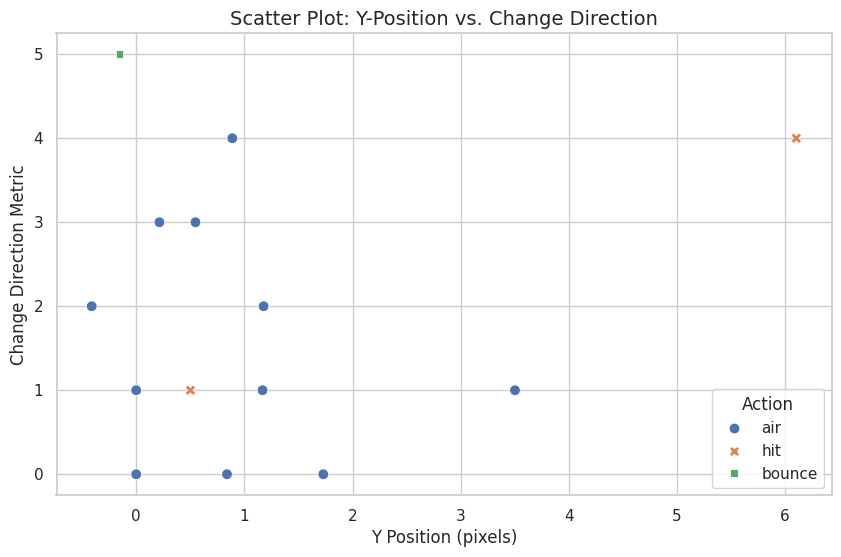

In [125]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the visual style
sns.set_theme(style="whitegrid")

# Create the scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=test_df, 
    x='impact_score', 
    y='dist_to_event', 
    hue='action',    # Colors points based on 'action' (air, hit, bounce)
    style='action',  # Changes point shape based on 'action'
    palette='deep',  # Color palette
    s=60             # Size of points
)

# Add titles and labels
plt.title('Scatter Plot: Y-Position vs. Change Direction', fontsize=14)
plt.xlabel('Y Position (pixels)', fontsize=12)
plt.ylabel('Change Direction Metric', fontsize=12)
plt.legend(title='Action')

# Show the plot
plt.show()

In [127]:
test_df.isna().sum()

x                0
y                0
visible          0
action           0
cosine_sim       0
speed_delta      0
y_distortion     0
x_distortion     0
acc_x            0
acc_y            0
acc_mag          0
impact_score     0
cluster          0
past_avg_x       0
past_avg_y       0
future_avg_x     0
future_avg_y     0
dist_to_event    0
dtype: int64

Preview of PCA Data:
        PC1       PC2 action  frame_index
0 -2.086730 -1.222843    air       324564
1 -2.127239 -1.229800    air       324565
2 -2.177932 -1.241582    air       324566
3 -2.226483 -1.248385    air       324567
4 -2.270607 -1.254704    air       324568


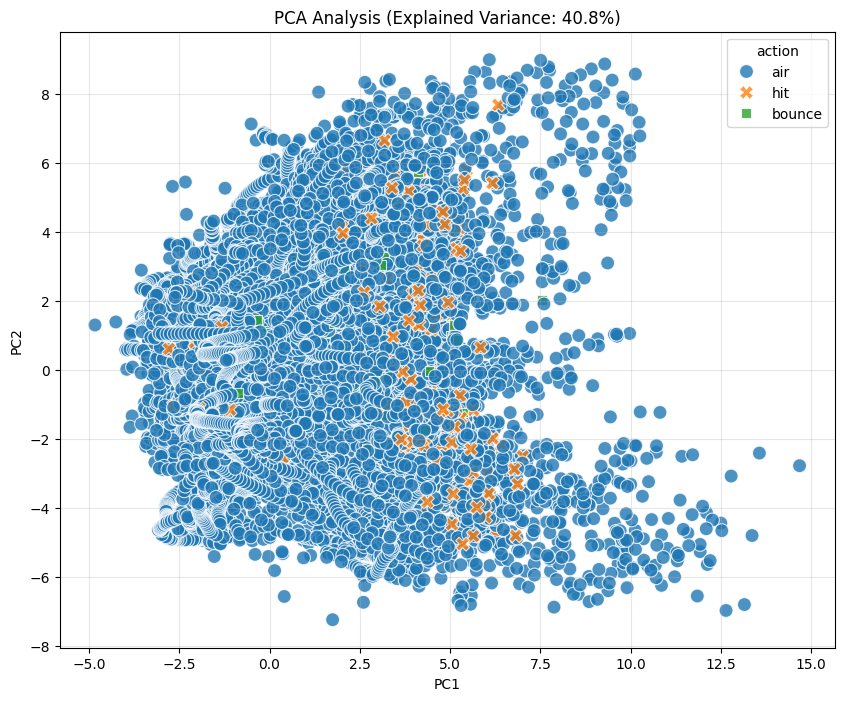

In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# 1. Setup Features
features = [
    'cosine_sim', 'speed_delta', 
    'acc_mag', 'acc_x', 'acc_y', 
    'impact_score', 'dist_to_event'
]

# 2. Prepare X (Standardize)
X = df.drop(columns=['action','filename']) # No dropna needed since you confirmed no NaNs
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 3. Run PCA
pca = PCA(n_components=2)
principal_components = pca.fit_transform(X_scaled)

# 4. Create PCA DataFrame
pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])

# --- THE FIX IS HERE ---
# Use .values to ignore the index mismatch
pca_df['action'] = df['action'].values
#pca_df['cluster'] = df['cluster'].values
pca_df['frame_index'] = df.index.values

# 5. Check before plotting (Debug step)
print("Preview of PCA Data:")
print(pca_df.head()) # Ensure 'action' is NOT NaN here

# 6. Visualization
plt.figure(figsize=(10, 8))
sns.scatterplot(
    data=pca_df, 
    x='PC1', 
    y='PC2', 
    hue='action',    # Now this will work
    style='action',
    s=100, 
    alpha=0.8
)

plt.title(f'PCA Analysis (Explained Variance: {sum(pca.explained_variance_ratio_):.1%})')
plt.grid(True, alpha=0.3)
plt.show()

In [28]:
from sklearn.manifold import TSNE

# 1. Run t-SNE
# perplexity: roughly sqrt(N), but for small data try 2-5
tsne = TSNE(n_components=2, perplexity=5, random_state=42, init='pca', learning_rate='auto')
X_embedded = tsne.fit_transform(X_scaled)

# 2. Create DataFrame
tsne_df = pd.DataFrame(X_embedded, columns=['Dim1', 'Dim2'])
tsne_df['action'] = test_df['action'].values
# 3. Plot
plt.figure(figsize=(10, 8))
sns.scatterplot(
    data=tsne_df, x='Dim1', y='Dim2', 
    hue='action', style='action', s=100
)
plt.title("t-SNE Visualization (Non-Linear)")
plt.show()

KeyboardInterrupt: 

In [140]:
df

,x,y,visible,action,cosine_sim,speed_delta,y_distortion,x_distortion,acc_x,acc_y,acc_mag,impact_score,cluster,past_avg_x,past_avg_y,future_avg_x,future_avg_y,dist_to_event
235716,1072,532,True,air,1.000000,15.542860,1.0,1.0,0.0,0.0,0.0,0.0,1,1072.000000,532.000000,1062.20000,524.2,20
235717,1068,528,True,air,0.997829,9.454771,1.0,1.0,0.0,0.0,0.0,0.0,1,1072.000000,532.000000,1059.60000,522.4,19
235718,1065,526,True,air,0.989376,4.515751,1.0,1.0,0.0,0.0,0.0,0.0,1,1070.000000,530.000000,1056.80000,520.8,18
235719,1063,524,True,air,0.975331,-0.034468,1.0,1.0,0.0,0.0,0.0,0.0,1,1068.333333,528.666667,1053.40000,519.8,17
235720,1059,522,True,air,0.954027,-2.967013,1.0,1.0,0.0,0.0,0.0,0.0,1,1067.000000,527.500000,1050.60000,519.0,16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235856,1085.985149,979.5,True,bounce,-0.773878,-69.169197,-1.0,-1.0,0.0,0.0,0.0,0.0,0,1066.400000,835.000000,1064.99703,972.9,1
235864,1096,1024,True,air,-0.873933,-45.843369,-1.0,-1.0,0.0,0.0,0.0,0.0,0,1072.197030,876.500000,1064.99703,972.9,0
235876,1074,988,True,air,-0.858088,-12.653191,-1.0,1.0,0.0,0.0,0.0,0.0,0,1078.997030,920.900000,1064.99703,972.9,1
235877,1071,983,True,air,-0.385422,24.175785,1.0,1.0,0.0,0.0,0.0,0.0,1,1080.597030,952.300000,1064.99703,972.9,2


In [30]:
df['diff_position_x']=df['past_avg_x']-df['future_avg_x']
df['diff_position_y']=df['past_avg_y']-df['future_avg_y']


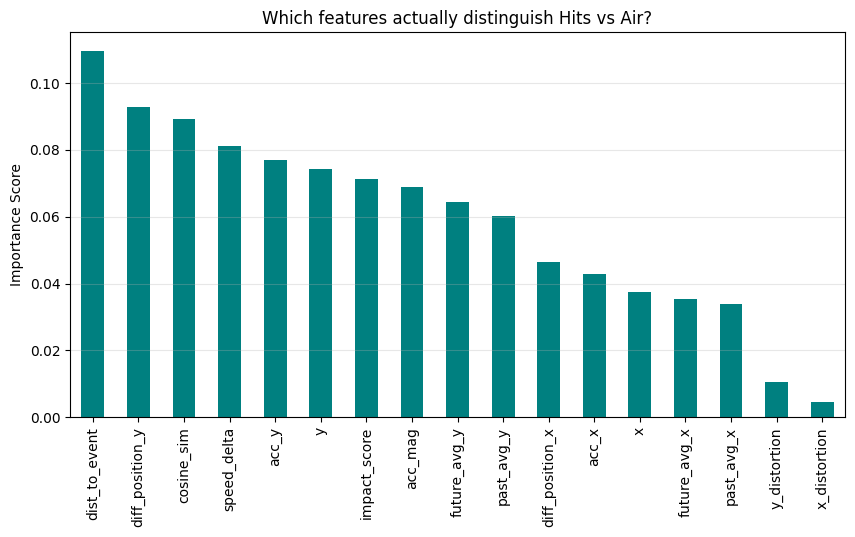

In [34]:
from sklearn.ensemble import RandomForestClassifier

# 1. Train a quick model
model = RandomForestClassifier(n_estimators=50, random_state=42)
y = df['action']

model.fit(df.drop(columns=['action','filename']), y)

# 2. Get Importance
importances = pd.Series(model.feature_importances_, index=df.drop(columns=['action','filename']).columns).sort_values(ascending=False)

# 3. Plot
plt.figure(figsize=(10, 5))
importances.plot(kind='bar', color='teal')
plt.title("Which features actually distinguish Hits vs Air?")
plt.ylabel("Importance Score")
plt.grid(axis='y', alpha=0.3)
plt.show()

In [35]:
df.columns

Index(['x', 'y', 'action', 'filename', 'cosine_sim', 'speed_delta',
       'y_distortion', 'x_distortion', 'acc_x', 'acc_y', 'acc_mag',
       'impact_score', 'past_avg_x', 'past_avg_y', 'future_avg_x',
       'future_avg_y', 'dist_to_event', 'diff_position_x', 'diff_position_y'],
      dtype='object')

In [36]:
features=['y','cosine_sim','speed_delta',
       'acc_y', 'acc_mag',
       'impact_score', 'past_avg_x', 'past_avg_y',
       'future_avg_y', 'dist_to_event','diff_position_y']

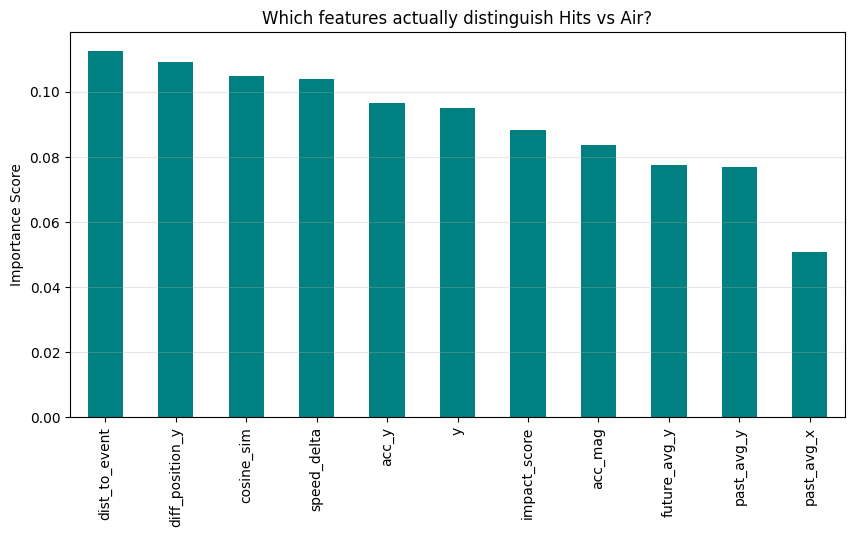

In [37]:
from sklearn.ensemble import RandomForestClassifier

# 1. Train a quick model
model = RandomForestClassifier(n_estimators=50, random_state=42)
y = df['action']

model.fit(df[features], y)

# 2. Get Importance
importances = pd.Series(model.feature_importances_, index=features).sort_values(ascending=False)

# 3. Plot
plt.figure(figsize=(10, 5))
importances.plot(kind='bar', color='teal')
plt.title("Which features actually distinguish Hits vs Air?")
plt.ylabel("Importance Score")
plt.grid(axis='y', alpha=0.3)
plt.show()

In [38]:
model_df=df[features]

In [42]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import seaborn as sns


scaler = StandardScaler()
X_scaled = scaler.fit_transform(model_df)

# Fit K-Means
kmeans = KMeans(n_clusters=2, random_state=42, n_init=20)
df['cluster'] = kmeans.fit_predict(X_scaled)


In [43]:
model_df

,y,cosine_sim,speed_delta,acc_y,acc_mag,impact_score,past_avg_x,past_avg_y,future_avg_y,dist_to_event,diff_position_y
324564,257,1.000000,28.488222,0.0,0.0,0.0,849.000000,257.000000,236.6,12,20.400000
324565,251,0.999349,17.733969,0.0,0.0,0.0,849.000000,257.000000,230.4,11,26.600000
324566,243,0.999888,7.305801,0.0,0.0,0.0,849.500000,254.000000,225.4,10,28.600000
324567,236,0.999832,-1.429478,0.0,0.0,0.0,849.333333,250.333333,220.4,9,29.933333
324568,230,0.994494,-9.690998,0.0,0.0,0.0,849.500000,246.750000,215.0,8,31.750000
...,...,...,...,...,...,...,...,...,...,...,...
655760,401,0.931712,-2.820119,0.0,0.0,0.0,1026.600000,412.400000,395.8,17,16.600000
655761,398,0.854409,-4.013433,0.0,0.0,0.0,1025.800000,408.400000,395.8,18,12.600000
655762,396,0.840303,-6.129602,0.0,0.0,0.0,1024.800000,404.800000,395.8,19,9.000000
655763,393,0.854253,-8.688944,0.0,0.0,0.0,1024.000000,401.600000,395.8,20,5.800000


In [44]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Create the contingency table
# Rows = Actual Actions (Ground Truth)
# Columns = Predicted Clusters (0, 1, 2)
crosstab = pd.crosstab(df['action'], df['cluster'])

print("--- Confusion Matrix (Counts) ---")
print(crosstab)

--- Confusion Matrix (Counts) ---
cluster      0      1
action               
air      74839  35788
bounce     709    737
hit        806    794


/tmp/ipykernel_112072/2622060396.py:7: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  T = df[features].fillna(0).astype(float)


Best Motif found at Frame 37468 and Frame 39759


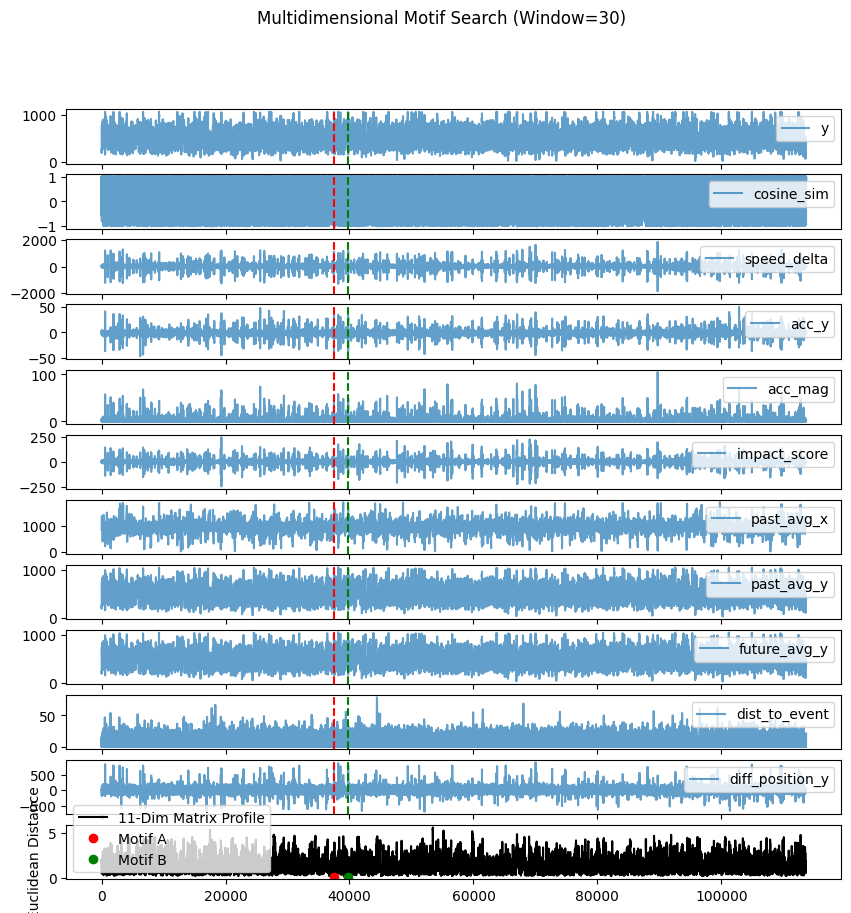

In [45]:
import stumpy
import numpy as np
import matplotlib.pyplot as plt

# 1. Select your features
# Ensure data is float and clean (No NaNs allowed in standard STUMPY)
T = df[features].fillna(0).astype(float)

# 2. Define Window Size (m)
# How long is a typical "event"? (e.g., 30 frames for a shot)
m = 30 

# 3. Run MSTUMP
# Returns: mps (Matrix Profiles), indices (Index of nearest neighbor)
# Shape of mps: (number_of_dimensions, result_length)
mps, indices = stumpy.mstump(T, m)

# 4. Extract the "Full Dimensional" Matrix Profile
# We usually want the last row, which considers ALL dimensions (k=4)
k = len(features)
P = mps[k-1]         # The Matrix Profile using all 4 features
I = indices[k-1]     # The indices of the nearest neighbors

# 5. Find the Top Motif (The lowest distance)
motif_idx = np.argsort(P)[0]      # Index of the best match (Pattern A)
nearest_neighbor_idx = I[motif_idx] # Index of the similar sequence (Pattern B)

print(f"Best Motif found at Frame {motif_idx} and Frame {nearest_neighbor_idx}")

# --- PLOTTING ---
fig, axs = plt.subplots(T.shape[1] + 1, sharex=True, figsize=(10, 10))

# Plot raw dimensions
for i, col in enumerate(features):
    axs[i].plot(T[col].values, label=col, alpha=0.7)
    axs[i].legend(loc="upper right")
    
    # Highlight the motif
    axs[i].axvline(motif_idx, color='r', linestyle='--')
    axs[i].axvline(nearest_neighbor_idx, color='g', linestyle='--')

# Plot the Multidimensional Matrix Profile
axs[-1].plot(P, color='black', label=f'{k}-Dim Matrix Profile')
axs[-1].set_ylabel("Euclidean Distance")
axs[-1].plot(motif_idx, P[motif_idx], "ro", label="Motif A")
axs[-1].plot(nearest_neighbor_idx, P[nearest_neighbor_idx], "go", label="Motif B")
axs[-1].legend()

plt.suptitle(f"Multidimensional Motif Search (Window={m})")
plt.show()